In [20]:
#Import required libraries and packages
import os, shutil

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import gc
import cv2
import cupy as cp
import pydicom
from pydicom.pixel_data_handlers.util import apply_modality_lut
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from glob import glob
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

In [3]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    RESIZE_DIM = 256
    TARGET_COLS = [
        'bowel_injury', 'extravasation_injury',
        'kidney_healthy', 'kidney_low', 'kidney_high',
        'liver_healthy', 'liver_low', 'liver_high',
        'spleen_healthy', 'spleen_low', 'spleen_high',
    ]
#Create an instance of the Config Class
config = Config()

# Data Pipeline

## Dataset Overview:

The dataset supplied for this competition is initially in DICOM format, a standard for medical imaging. However, for the purpose of our training pipeline, we have opted to use PNG images extracted from the DICOM format.

**Reasoning:**

1. **Compatibility and Standardization:**
   - **DICOM (Digital Imaging and Communications in Medicine):** DICOM is a widely accepted standard for medical imaging, ensuring compatibility across different medical devices and systems. However, it is not inherently suitable for deep learning frameworks.
   - **PNG (Portable Network Graphics):** PNG, on the other hand, is a format specifically designed for the web but is easily interpretable by various image processing libraries used in machine learning frameworks. Using PNG allows us to leverage the flexibility and ease of integration offered by common image handling tools.

2. **Simplified Preprocessing:**
   - **DICOM:** DICOM files often contain a plethora of metadata and additional information that might not be relevant for our specific machine learning task. Extracting and processing this information can be computationally intensive.
   - **PNG:** By converting DICOM to PNG, we streamline the preprocessing pipeline. PNG images typically retain only the essential visual information, making it easier to handle and reducing the complexity of our data preparation steps.

3. **Community Support:**
   - **PNG:** The machine learning community has developed extensive tooling and resources around common image formats like PNG. This includes pre-trained models, data augmentation techniques, and a wealth of knowledge on best practices. Utilizing PNG aligns our approach with community standards, facilitating collaboration and knowledge exchange.

4. **Visualization and Interpretability:**
   - **PNG:** PNG images are easily viewable with standard image viewers and can be more intuitively interpreted by researchers and medical professionals. This facilitates the collaborative analysis of the dataset and the validation of model outputs.

5. **Storage Efficiency:**
   - **PNG:** While DICOM is efficient for storage of medical imaging data, for our specific machine learning application, PNG can be more storage-friendly. PNG compression is lossless, maintaining image quality while potentially reducing storage requirements compared to DICOM.

In summary, the decision to work with PNG images derived from DICOM is driven by a combination of technical compatibility, ease of preprocessing, community support, visualization benefits, and storage considerations tailored to the requirements of our machine learning workflow.

In [4]:
MAIN_FOLDER = '/kaggle/input/rsna-2023-abdominal-trauma-detection'
IMAGE_DIR = '/tmp/dataset/rsna-atd'
Stride = 10
!ls {MAIN_FOLDER}

image_level_labels.csv	 test_images		   train_images
sample_submission.csv	 test_series_meta.csv	   train_series_meta.csv
segmentations		 train.csv
test_dicom_tags.parquet  train_dicom_tags.parquet


## Metadata Overview

**The train.csv file provides comprehensive meta-information, including:**

* **patient_id:** A distinctive identification code assigned to each patient.
* **series_id:** A unique identifier for each scan, facilitating traceability.
* **instance_number:** Denotes the image sequence within a scan. Notably, the starting instance number is often above zero due to the initial cropping of scans to the abdomen.
* **[bowel/extravasation]_[healthy/injury]:** Presents binary targets for two distinct injury types, namely bowel and extravasation.
* **[kidney/liver/spleen]_[healthy/low/high]:** Offers a nuanced perspective with three target levels for three injury types: kidney, liver, and spleen.
* **any_injury:** Indicates whether a patient experienced any form of injury during the course of observation.

This structured metadata is instrumental for comprehending and navigating the dataset. The patient_id and series_id enable unique patient and scan identification, while instance_number provides insights into the sequential order of images within scans. The injury-related fields afford a detailed breakdown, categorizing injuries into binary and trinary classifications. Lastly, any_injury serves as a concise flag denoting the overall injury status of each patient. This clear delineation of metadata categories enhances the dataset's interpretability, facilitating efficient analysis and model training.

In [5]:
#Read CSV files
meta_train_df = pd.read_csv(f'{MAIN_FOLDER}/train_series_meta.csv')

#Checking if patients are repeated by finding the number of unique patient IDs
num_train_rows = meta_train_df.shape[0]
unique_train_patients = meta_train_df['patient_id'].nunique()

print(f'{num_train_rows=}')
print(f'{unique_train_patients=}')

num_train_rows=4711
unique_train_patients=3147


In [6]:
#Read CSV files
meta_test_df = pd.read_csv(f'{MAIN_FOLDER}/test_series_meta.csv')

#Checking if patients are repeated by finding the number of unique patient IDs
num_test_rows = meta_test_df.shape[0]
unique_test_patients = meta_train_df['patient_id'].nunique()

print(f'{num_test_rows=}')
print(f'{unique_test_patients=}')

num_test_rows=6
unique_test_patients=3147


In [8]:
#Read CSV files
train_df = pd.read_csv(os.path.join(MAIN_FOLDER, 'train.csv'))
img_lvl_df = pd.read_csv(os.path.join(MAIN_FOLDER, 'image_level_labels.csv'))

#Merge DataFrames
train_df = pd.merge(train_df, img_lvl_df, on='patient_id', how='right')

#Construct image_path using os.path.join
train_df['image_path'] = train_df.apply(
    lambda row: os.path.join(MAIN_FOLDER, 'train_images', str(row['patient_id']),
                             str(row['series_id']), f"{row['instance_number']}.dcm"),
    axis=1
)

#Drop duplicates
train_df.drop_duplicates()

train_df.head()


,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
1,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
2,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,364,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
3,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,365,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
4,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,366,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...


In [9]:
#Checking if patients are repeated by finding the number of unique patient IDs for train data
num_rows = train_df.shape[0]
unique_patients = train_df['patient_id'].nunique()

print(f'{num_rows=}')
print(f'{unique_patients=}')

num_rows=12029
unique_patients=246


In [41]:
#Glob for DICOM files in the specified directory
test_paths = glob('/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images/*/*/*dcm')

#Create a DataFrame to organize the test dataset
test_df = pd.DataFrame(test_paths, columns=["image_path"])

#Extract patient_id, series_id, and instance_number from the file path and convert to integer
test_df['patient_id'] = test_df.image_path.map(lambda x: x.split('/')[-3]).astype(int)
test_df['series_id'] = test_df.image_path.map(lambda x: x.split('/')[-2]).astype(int)
test_df['instance_number'] = test_df.image_path.map(lambda x: x.split('/')[-1].replace('.dcm','')).astype(int)

print('Test:')
print(f'# Size: {len(test_df)}')
display(test_df.head())



Test:
# Size: 3


,image_path,patient_id,series_id,instance_number
0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,63706,39279,30
1,/kaggle/input/rsna-2023-abdominal-trauma-detec...,50046,24574,30
2,/kaggle/input/rsna-2023-abdominal-trauma-detec...,48843,62825,30


In [11]:
#Checking if patients are repeated by finding the number of unique patient IDs for test data
num_rows = test_df.shape[0]
unique_patients = test_df['patient_id'].nunique()

print(f'{num_rows=}')
print(f'{unique_patients=}')

num_rows=3
unique_patients=3


## DICOM to PNG pipeline

In [12]:
#Remove the directory and its contents (if it exists)
!rm -r {IMAGE_DIR}

#Create 'train_images' and 'test_images' directories within IMAGE_DIR
os.makedirs(f'{IMAGE_DIR}/train_images', exist_ok=True)
os.makedirs(f'{IMAGE_DIR}/test_images', exist_ok=True)

rm: cannot remove '/tmp/dataset/rsna-atd': No such file or directory


In [32]:
def standardize_pixel_array(dcm):
    """
    Standardize pixel array based on DICOM metadata.
    
    Args:
        dcm (pydicom.dataset.FileDataset): DICOM file dataset.
    
    Returns:
        numpy.ndarray: Standardized pixel array.
    """
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        pixel_array = (pixel_array << bit_shift).astype(pixel_array.dtype)
        pixel_array = apply_modality_lut(pixel_array, dcm)
    return pixel_array

def read_xray(path, fix_monochrome=True):
    """
    Read X-ray DICOM file, standardize pixel array, and normalize the values.
    
    Args:
        path (str): File path to the X-ray DICOM file.
        fix_monochrome (bool): Flag to fix monochrome inversion if PhotometricInterpretation is 'MONOCHROME1'.
    
    Returns:
        numpy.ndarray: Normalized pixel values of the X-ray image.
    """
    dicom = pydicom.dcmread(path)
    data = standardize_pixel_array(dicom)

    #Normalize pixel values
    data = (data - np.min(data)) / (np.max(data) + 1e-5)

    #Fix monochrome if needed
    if fix_monochrome and dicom.PhotometricInterpretation == 'MONOCHROME1':
        data = 1.0 - data

    return data

def resize_and_save(file_path, resize_dim=(config.RESIZE_DIM, config.RESIZE_DIM)):
    """
    Resize image, convert to uint8, and save to a new location.
    Returns patient, study, image IDs, original width, and height.
    
    Args:
        file_path (str): File path to the X-ray DICOM file.
        resize_dim (tuple): Dimensions for resizing the image.
    
    Returns:
        tuple: Patient ID, Study ID, Image ID, Original Width, Original Height.
    """
    img = read_xray(file_path)
    h, w = img.shape[:2]
    
    #Resize using Cupy and convert to NumPy
    img = cp.asnumpy(cv2.resize(cp.asnumpy(img), resize_dim, cv2.INTER_LINEAR))
    
    #Scale to uint8 
    img = cp.asnumpy((img * 255).astype(np.uint8))
    
    #Extract patient, study, and image IDs
    sub_path = file_path.split("/", 4)[-1].split('.dcm')[0] + '.png'
    infos = sub_path.split('/')
    pid = infos[-3]
    sid = infos[-2]
    iid = infos[-1]; iid = iid.replace('.png','')
    
    #Create new path
    new_path = os.path.join(IMAGE_DIR, sub_path)
    os.makedirs(os.path.dirname(new_path), exist_ok=True)
    
    #Save the resized image directly
    cv2.imwrite(new_path, img)

    return pid, sid, iid, w, h


In [33]:
def process_images_in_parallel(file_paths):
    """
    Process images in parallel using ThreadPoolExecutor.
    
    Args:
        file_paths (list): List of file paths to X-ray DICOM images.
        
    Returns:
        list: A list containing the sizes of processed images.
    """
    with ThreadPoolExecutor(max_workers=4) as executor:
        #Use ThreadPoolExecutor to parallelize image processing using the resize_and_save function
        image_sizes = list(tqdm(
            executor.map(resize_and_save, file_paths),
            total=len(file_paths),
            leave=True
        ))
    return image_sizes

file_train_paths = train_df.image_path.tolist()

#Process images in parallel and measure time
start_time = time.time()
train_img_sizes = process_images_in_parallel(file_train_paths)
end_time = time.time()

print(f"Total time taken: {end_time - start_time} seconds")

# Perform garbage collection to free up resources
gc.collect()



100%|██████████| 12029/12029 [02:30<00:00, 80.08it/s] 


Total time taken: 150.4931046962738 seconds


156892

In [37]:
#Unpack imgsize_train list of tuples into separate lists
pid, sid, iid, width, height = zip(*train_img_sizes)

#Create a DataFrame with the extracted information
meta_df = pd.DataFrame({
    'patient_id_meta': pid,
    'series_id_meta': sid,
    'instance_number_meta': iid,
    'width': width,
    'height': height
})

#Convert specific columns to integer type
columns_to_convert = ['patient_id_meta', 'series_id_meta', 'instance_number_meta']
meta_df[columns_to_convert] = meta_df[columns_to_convert].astype(int)

#Merge the DataFrames based on specific columns or index
train_df = pd.concat([train_df, meta_df], axis=1) 

#Drop the redundant columns
train_df = train_df.drop(columns=['patient_id_meta', 'series_id_meta', 'instance_number_meta'])

train_df.head()


,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...,512,512
2,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,364,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...,512,512
3,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,365,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...,512,512
4,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,366,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...,512,512


In [38]:
file_test_paths = test_df.image_path.tolist()

#Process images and measure time
import time
start_time = time.time()
test_img_sizes = process_images_in_parallel(file_test_paths)
end_time = time.time()

print(f"Total time taken: {end_time - start_time} seconds")

# Perform garbage collection
gc.collect()

100%|██████████| 3/3 [00:00<00:00, 65.30it/s]


Total time taken: 0.05211901664733887 seconds


94

In [42]:
#Unpack imgsize_train list of tuples into separate lists
pid, sid, iid, width, height = zip(*test_img_sizes)

#Create a DataFrame with the extracted information
meta_df = pd.DataFrame({
    'patient_id_meta': pid,
    'series_id_meta': sid,
    'instance_number_meta': iid,
    'width': width,
    'height': height
})

#Convert specific columns to integer type
columns_to_convert = ['patient_id_meta', 'series_id_meta', 'instance_number_meta']
meta_df[columns_to_convert] = meta_df[columns_to_convert].astype(int)

#Merge the DataFrames based on specific columns or index
test_df = pd.concat([test_df, meta_df], axis=1) 

#Drop the redundant columns
test_df = test_df.drop(columns=['patient_id_meta', 'series_id_meta', 'instance_number_meta'])

test_df.head()


,image_path,patient_id,series_id,instance_number,width,height
0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,63706,39279,30,512,512
1,/kaggle/input/rsna-2023-abdominal-trauma-detec...,50046,24574,30,512,512
2,/kaggle/input/rsna-2023-abdominal-trauma-detec...,48843,62825,30,512,512


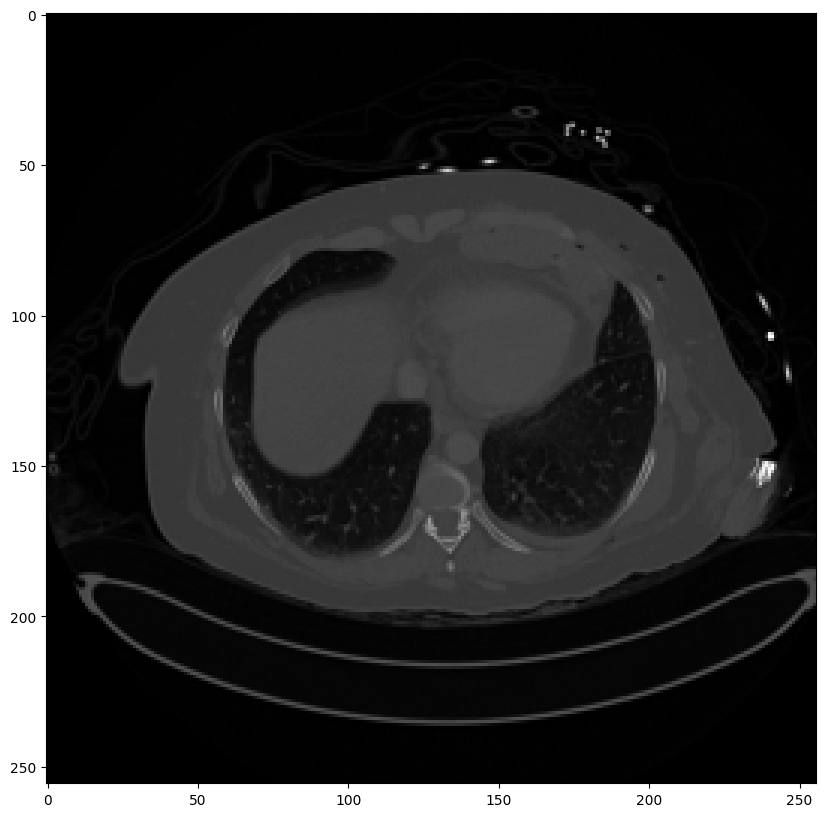

In [44]:
#Filter the DataFrame based on the condition
filtered_train_df = train_df[train_df.width < 700]
#Get the image path from the filtered DataFrame
image_path = filtered_train_df.image_path.iloc[0].replace(MAIN_FOLDER, IMAGE_DIR).replace('.dcm', '.png')
#Read the image using cv2
img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

#Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.show()

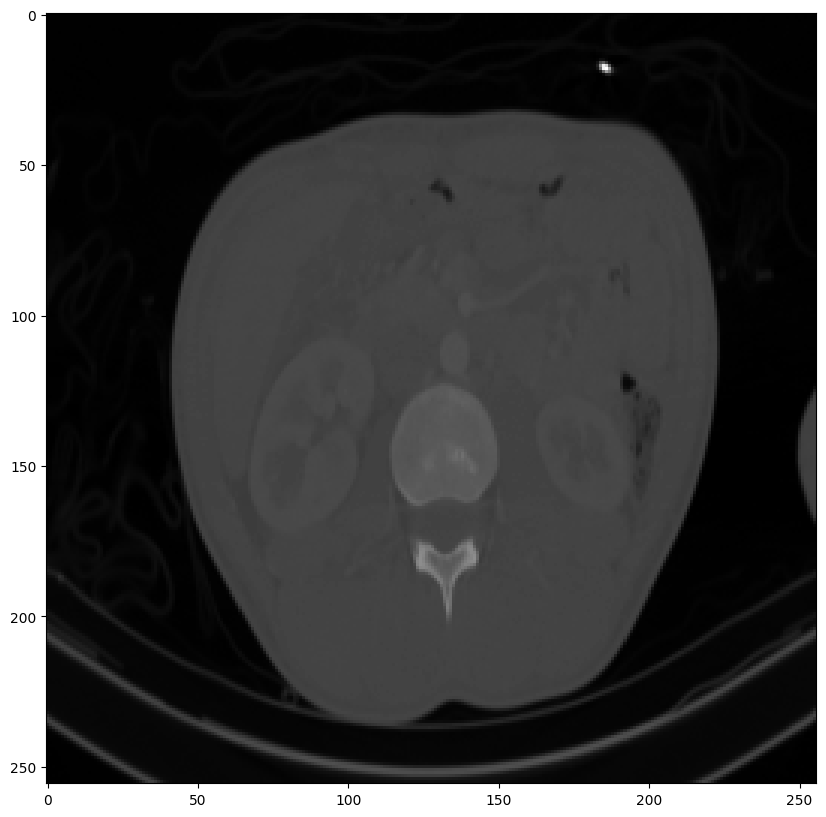

In [45]:
#Filter the DataFrame based on the condition
filtered_train_df = train_df[train_df.width > 700]
#Check if there are any matching rows
if not filtered_train_df.empty:
    #Get the image path from the filtered DataFrame
    image_path = filtered_train_df.image_path.iloc[0].replace(MAIN_FOLDER, IMAGE_DIR).replace('.dcm', '.png')
    #Read the image using cv2
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    #Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')
    plt.show()
else:
    print("No images found for the specified condition.")

# Creating CSV

In [47]:
#Save DataFrames to CSV files
train_df.to_csv(f'{IMAGE_DIR}/train.csv', index=False)
test_df.to_csv(f'{IMAGE_DIR}/test.csv', index=False)

#Copy additional metadata files to the target directory
shutil.copy(f'{MAIN_FOLDER}/train_series_meta.csv', f'{IMAGE_DIR}/')
shutil.copy(f'{MAIN_FOLDER}/test_series_meta.csv', f'{IMAGE_DIR}/')
shutil.copy(f'{MAIN_FOLDER}/sample_submission.csv', f'{IMAGE_DIR}/')


'/tmp/dataset/rsna-atd/sample_submission.csv'

In [48]:
#List directory contents
!ls -al {IMAGE_DIR}

total 1872
drwxr-xr-x   4 root root    4096 Oct  4 14:50 .
drwxr-xr-x   3 root root    4096 Oct  4 14:01 ..
-rw-r--r--   1 root root     771 Oct  4 14:50 sample_submission.csv
-rw-r--r--   1 root root     376 Oct  4 14:50 test.csv
drwxr-xr-x   5 root root    4096 Oct  4 14:46 test_images
-rw-r--r--   1 root root     138 Oct  4 14:50 test_series_meta.csv
-rw-r--r--   1 root root 1793767 Oct  4 14:50 train.csv
drwxr-xr-x 248 root root    4096 Oct  4 14:24 train_images
-rw-r--r--   1 root root   92899 Oct  4 14:50 train_series_meta.csv


# Creating Dataset

In [49]:
#Create a ZipFile object for writing
zipObj = ZipFile(f'/kaggle/working/rsna-acd-processed.zip', 'w')

#Gather file paths from the specified IMAGE_DIR and its subdirectories
file_paths = glob(f'{IMAGE_DIR}/**/*', recursive=True)

#Print the total number of files to be zipped
print(f'Total Files: {len(file_paths)}')

#Begin zipping process
print('Zipping...')
for file_path in tqdm(file_paths):
    #Write the file to the zip archive, using a relative path within the archive
    zipObj.write(file_path, file_path[len(IMAGE_DIR):])
    
    # emove the original file after adding to the zip archive
    os.remove(file_path) if os.path.isfile(file_path) else None

#Close the ZipFile object
zipObj.close()


Total Files:33538
Zippping...


100%|██████████| 33538/33538 [00:05<00:00, 5919.59it/s]
